In [1]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

%cd /content/drive/MyDrive/pixelNeRF

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1g2dktPblP5elov4ll96wfHuJKzZndl5X/pixelNeRF


In [2]:
# Usage: bash scripts/fetch2local.sh -from <bucket/prefix> [-to <extract_path>]
#       -to : /content/pixNeRF_shapeNet_v2_data [DEFAULT]
!bash fetch2local.sh -from nerf-data-ssu/shapeNetV2_cars

Pixel-NeRF GCS Fetcher (Stable v2)
------------------------------------------
BUCKET   : nerf-data-ssu
PREFIX   : shapeNetV2_cars
SOURCE   : gs://nerf-data-ssu/shapeNetV2_cars
ZIP SAVE : /content/load_data
EXTRACT  : /content/pixNeRF_shapeNet_v2_data
Installing crcmod...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Skipping Colab authentication (not detected).
Scanning for ZIP files in gs://nerf-data-ssu/shapeNetV2_cars...
 [ Found 5 ZIP files ]
gs://nerf-data-ssu/shapeNetV2_cars/cars_test.zip
gs://nerf-data-ssu/shapeNetV2_cars/cars_train.zip
gs://nerf-data-ssu/shapeNetV2_cars/cars_train_test.zip
gs://nerf-data-ssu/shapeNetV2_cars/cars_train_val.zip
gs://nerf-data-ssu/shapeNetV2_cars/cars_val.zip
------------------------------------------
 [ Download ] ZIP files to /content/load_data...
Copying gs://nerf-data-ssu/shapeNetV2_cars/cars_test.zip...
Copying gs://nerf-data-ssu/shapeNetV2_cars/cars_train.zip...
Copyi

- 추론용 데이터(예시) 샘플링

 [ Cleared ] : data/input/
 [ Object ID ] : 1523402e11400b75becf71e2e014ff6f
✅ Data ready at: data/input/example1

 [ Data Path ] : data/input/example1


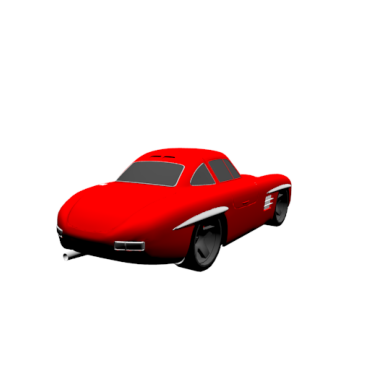

In [3]:
import os
import glob
import shutil
import importlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from inference import DataPreprocessor


# ================= Configuration =================
SOURCE_DATA_ROOT = "/content/pixNeRF_shapeNet_v2_data/cars_test"
TARGET_ROOT = "data/input/"
OUTPUT_DIR_NAME = "example1"
NUM_VIEWS = 6
MAX_ELEVATION = 50.0
TARGET_ID = "1523402e11400b75becf71e2e014ff6f"
# =================================================

preprocessor = DataPreprocessor(SOURCE_DATA_ROOT, TARGET_ROOT, OUTPUT_DIR_NAME)
generated_path, selected_obj_id = preprocessor.prepare_data(NUM_VIEWS, MAX_ELEVATION, TARGET_ID)

if generated_path:
    print(f"\n [ Data Path ] : {generated_path}")
    preview_images = glob.glob(os.path.join(generated_path, 'rgb', '*'))
    if preview_images:
        plt.imshow(mpimg.imread(preview_images[0]))
        plt.axis('off')
        plt.show()

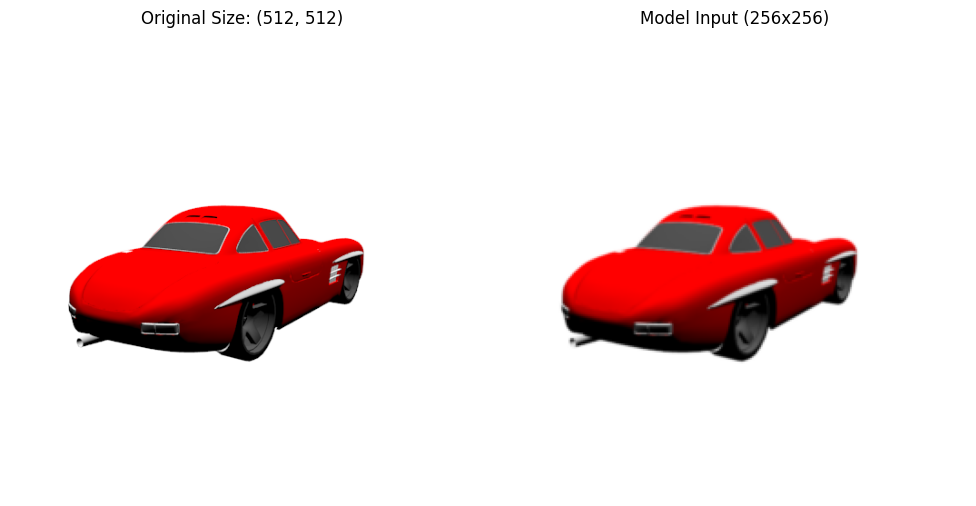

[ Loaded ] : 000027.png


In [4]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

# ================= Configuration =================
INPUT_DIR = "data/input/example1/rgb"  # 이미지가 저장된 경로
TARGET_SIZE = (256, 256)               # 모델에 들어가는 크기
# =================================================

def show_resized_example():
    # 1. 이미지 파일 찾기
    img_paths = sorted(glob.glob(os.path.join(INPUT_DIR, "*.[pj][np]g")))

    if not img_paths:
        print(f"❌ '{INPUT_DIR}' 경로에 이미지가 없습니다.")
        return

    # 2. 첫 번째 이미지 가져오기 (원하는 인덱스로 변경 가능)
    # 예: img_paths[0], img_paths[3] 등
    sample_path = img_paths[0]

    try:
        # 원본 로드
        original_img = Image.open(sample_path).convert("RGB")

        # 3. 리사이즈 (NeRF 모델이 보는 세상)
        resized_img = original_img.resize(TARGET_SIZE, Image.BILINEAR)

        # 4. 비교 출력
        plt.figure(figsize=(10, 5))

        # 원본
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title(f"Original Size: {original_img.size}")
        plt.axis("off")

        # (모델 시점)
        plt.subplot(1, 2, 2)
        plt.imshow(resized_img)
        plt.title(f"Model Input ({TARGET_SIZE[0]}x{TARGET_SIZE[1]})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        print(f"[ Loaded ] : {os.path.basename(sample_path)}")

    except Exception as e:
        print(f"⚠️ Error: {e}")

# 실행
show_resized_example()

# infer


1. 360도 비디오 생성
```
python inference.py --input_folder ./data/shapenet/cars_test/example_car \
                    --mode video \
                    --output_dir ./outputs_video
```

2. N개 뷰 생성
```
python inference.py --input_folder ./data/shapenet/cars_test/example_car \
                    --mode views \
                    --num_frames 50 \
                    --output_dir ./outputs_dataset
```


- N 개 뷰 생성


In [ ]:
TARGET_ROOT = "/data/input"      # 폴더 초기화
OUTPUT_DIR_NAME = "example1"      # 초기화 후 생성할 폴더 이름
INPUT_ROOT = TARGET_ROOT + "/" + OUTPUT_DIR_NAME
!python -u inference.py --input_folder {INPUT_ROOT} \
                        --mode views \
                        --num_frames 10 \
                        --output_dir ./outputs \
                        --size 128 \
                        # TTO 적용

- 360도 뷰 생성

In [16]:
TARGET_ROOT = "data/input/"      # 폴더 초기화
OUTPUT_DIR_NAME = "example1/"
INPUT_ROOT =  TARGET_ROOT + OUTPUT_DIR_NAME
!python -u inference.py --input_folder {INPUT_ROOT} \
                        --mode video \
                        --output_dir ./outputs \
                        --size 256 \
                        --num_frames 90 \
                        --obj_id {selected_obj_id} \
                        --n_fine 256

Initializing Model on cuda...
✅ Weights loaded successfully
📂 Loading data from: data/input/example1/ (Size: (256, 256))

[TTO] Starting Optimization for 500 steps...
   Optimizing | Avg Loss: 0.0011 | Avg PSNR: 29.65 dB: 100% 500/500 [11:47<00:00,  1.42s/it]
[TTO] Finished!

[Rendering] Generating Clean 360 Orbit Video...
  Views : 100%|███████████████████████████| 90/90 [1:48:00, Px: 64/64]
✨ Orbit Video saved to: ./outputs/orbit_1523402e11400b75becf71e2e014ff6f_256_6.mp4 (FPS: 30)


-  GT

📂 Processing Object ID: 1523402e11400b75becf71e2e014ff6f
📊 Stats: Median Ele 45.0°, Median Rad 1.300
✅ Selected View Index: 93
   - Azimuth: 359.6° (Target: 0°)
   - Elevation: 33.5° (Median: 45.0°)

✨ Image Saved: outputs/GT_start_frame_1523402e11400b75becf71e2e014ff6f_256.png


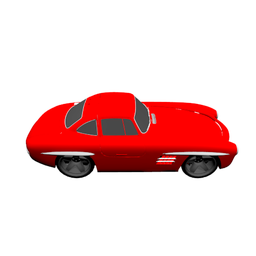

In [5]:
import os
import glob
import numpy as np
import torch
import imageio
from PIL import Image
import math

# ==========================================
# 1. 설정 (Configuration)
# ==========================================
OBJ_ID = "1523402e11400b75becf71e2e014ff6f"
SOURCE_DATA_ROOT = "/content/pixNeRF_shapeNet_v2_data/cars_test"
OUTPUT_DIR = "outputs"
RENDER_SIZE = 256

# 검색 범위: 0도 근처 ±10도 내의 사진을 찾음
SEARCH_WINDOW = 10.0

# ==========================================
# 2. 유틸리티 함수
# ==========================================
def parse_pose_file(path):
    with open(path, 'r') as f:
        values = [float(x) for x in f.read().split()]
    return torch.tensor(values, dtype=torch.float32).reshape(4, 4)

def get_raw_metrics(pose_raw):
    """inference.py와 동일한 기준(Raw Space)으로 각도 계산"""
    loc = pose_raw[:3, 3] # x, y, z
    radius = np.linalg.norm(loc)

    if radius == 0: elevation = 0
    else: elevation = np.degrees(np.arcsin(loc[2] / radius))

    azimuth = np.degrees(np.arctan2(loc[1], loc[0]))
    if azimuth < 0: azimuth += 360

    return radius, azimuth, elevation

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

# ==========================================
# 3. 데이터 로드 및 분석
# ==========================================
obj_dir = os.path.join(SOURCE_DATA_ROOT, OBJ_ID)
rgb_dir = os.path.join(obj_dir, 'rgb')
pose_dir = os.path.join(obj_dir, 'pose')

print(f"📂 Processing Object ID: {OBJ_ID}")

img_paths = sorted(glob.glob(os.path.join(rgb_dir, "*.png")) + glob.glob(os.path.join(rgb_dir, "*.jpg")))
pose_paths = sorted(glob.glob(os.path.join(pose_dir, "*.txt")))

if not img_paths: raise FileNotFoundError("❌ 데이터가 없습니다.")

# 전체 후보군 분석
all_candidates = []
for i in range(min(len(img_paths), len(pose_paths))):
    # Raw Pose 사용 (시작점 동기화 필수)
    pose_raw = parse_pose_file(pose_paths[i]).numpy()
    radius, azimuth, elevation = get_raw_metrics(pose_raw)

    all_candidates.append({
        'index': i,
        'radius': radius,
        'azimuth': azimuth,
        'elevation': elevation,
        'path': img_paths[i]
    })

# 기준점(Median) 계산 -> 줌(Zoom)과 높이 안정화를 위함
median_radius = np.median([c['radius'] for c in all_candidates])
median_elevation = np.median([c['elevation'] for c in all_candidates])

print(f"📊 Stats: Median Ele {median_elevation:.1f}°, Median Rad {median_radius:.3f}")

# ==========================================
# 4. 0도(Start) 이미지 찾기 및 보정
# ==========================================
TARGET_ANGLE = 0.0  # inference.py의 시작 각도

# 1. 0도 근처 후보 찾기
candidates = []
for item in all_candidates:
    diff = abs(item['azimuth'] - TARGET_ANGLE)
    diff = min(diff, 360 - diff) # 360도 경계 처리

    if diff <= SEARCH_WINDOW:
        candidates.append(item)

# 후보 없으면 가장 가까운 것 강제 선택
if not candidates:
    best_item = min(all_candidates, key=lambda x: min(abs(x['azimuth'] - TARGET_ANGLE), 360 - abs(x['azimuth'] - TARGET_ANGLE)))
    candidates = [best_item]

# 2. 최적의 1장 선발 (높이가 평균에 가장 가까운 것)
best_candidate = None
min_score = 9999.0

for cand in candidates:
    # 점수 = (높이 오차 x 10) + 각도 오차
    # 높이가 평균값(Median)과 비슷한 것을 최우선으로 뽑음
    ele_error = abs(cand['elevation'] - median_elevation)
    azi_error = min(abs(cand['azimuth'] - TARGET_ANGLE), 360 - abs(cand['azimuth'] - TARGET_ANGLE))

    score = (ele_error * 10.0) + azi_error

    if score < min_score:
        min_score = score
        best_candidate = cand

print(f"✅ Selected View Index: {best_candidate['index']}")
print(f"   - Azimuth: {best_candidate['azimuth']:.1f}° (Target: 0°)")
print(f"   - Elevation: {best_candidate['elevation']:.1f}° (Median: {median_elevation:.1f}°)")

# 3. 이미지 로드 및 줌 보정 (Stabilization)
img = Image.open(best_candidate['path']).convert("RGB")

# 거리(Radius)에 따른 크기 보정
scale_factor = best_candidate['radius'] / median_radius
target_scale_size = int(RENDER_SIZE * scale_factor)
if target_scale_size < RENDER_SIZE: target_scale_size = RENDER_SIZE

img_resized = img.resize((target_scale_size, target_scale_size), Image.LANCZOS)
final_img = crop_center(img_resized, RENDER_SIZE, RENDER_SIZE)

# ==========================================
# 5. 저장
# ==========================================
os.makedirs(OUTPUT_DIR, exist_ok=True)
save_filename = f"GT_start_frame_{OBJ_ID}_{RENDER_SIZE}.png"
save_path = os.path.join(OUTPUT_DIR, save_filename)

imageio.imwrite(save_path, np.array(final_img))

print(f"\n✨ Image Saved: {save_path}")

# Colab 미리보기
display(final_img)